In [1]:
import os
import gc
import pandas as pd
from tqdm.notebook import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
path_news = './stock/vn/business_news_en2/'
list_file_news = [os.path.join(path_news, filename) for filename in os.listdir(path_news) if os.path.isfile(os.path.join(path_news, filename))]

In [3]:
list_vn30 = pd.read_csv('list_vn_hsx30.csv')['symbol'].unique()

In [4]:
list_vn30

array(['ACB', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG',
       'KDH', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW',
       'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE'], dtype=object)

In [20]:
# def pos_tag_text(text):
#     stop_words = set(stopwords.words('english'))
#     pos_dict = {
#         'J' : wordnet.ADJ, 
#         'V' : wordnet.VERB, 
#         'N' : wordnet.NOUN, 
#         'R' : wordnet.ADV
#     }

#     text = re.sub('[^A-Za-z]+', ' ', text)
#     token = word_tokenize(text.lower())
#     words_list = [w for w in token if not w in stop_words]
#     pos_tagged = pos_tag(words_list)
#     pos_data = [(w, pos_dict.get(p[0])) for w, p in pos_tagged]
    
#     return pos_data

In [21]:
# def lemmatize_text(pos_data):
#     wordnet_lemmatizer = WordNetLemmatizer()
#     lemma_rew = " "
#     for word, pos in pos_data:
#         if pos is None:
#             lemma = word
#             lemma_rew = lemma_rew + " " + lemma
#         else:
#             lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
#             lemma_rew = lemma_rew + " " + lemma
            
#     return lemma_rew.strip()

In [22]:
# def sentiwordnet_analysis(pos_data):
#     wordnet_lemmatizer = WordNetLemmatizer()
#     tokens_count = 0
#     score_pos = 0
#     score_neg = 0
#     score_obj = 0
#     for word, pos in pos_data:
#         if not pos:
#             continue
            
#         lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
#         if not lemma:
#             continue
        
#         synsets = wordnet.synsets(lemma, pos=pos)
#         if not synsets:
#             continue
            
#         # Take the first sense, the most common
#         synset = synsets[0]
#         swn_synset = swn.senti_synset(synset.name())
        
#         score_pos += swn_synset.pos_score()
#         score_neg += swn_synset.neg_score()
#         score_obj += swn_synset.obj_score()
        
#         tokens_count += 1
    
#     score_total = score_pos - score_neg
    
#     return (score_pos, score_neg, score_obj, score_total)

In [5]:
lm_negative = pd.read_csv('lm_negative.csv', header=None)[0].tolist()
lm_negative = {word.lower() : -1 for word in lm_negative}

lm_positive = pd.read_csv('lm_positive.csv', header=None)[0].tolist()
lm_positive = {word.lower() : 1 for word in lm_positive}

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
              "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
              "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
              "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
              "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
              "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]
    
    if word.lower() in negate:
        return True
    else:
        return False

def lm_analysis(text):
    pos_count = 0
    neg_count = 0
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())
    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in lm_negative:
            neg_count += 1

        if input_words[i] in lm_positive:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 0:
                pos_count += 1
    
    if pos_count + neg_count > 0:
        polarity = (pos_count - neg_count) / (pos_count + neg_count)
    else:
        polarity = 0
    
    subjectivity = (pos_count + neg_count) / word_count if word_count > 0 else 0
    pos_rate = pos_count / word_count if word_count > 0 else 0
    neg_rate = neg_count / word_count if word_count > 0 else 0
    
    return {'Positive' : pos_rate, 
            'Negative' : neg_rate, 
            'Polarity' : polarity, 
            'Subjectivity' : subjectivity}

def lm_sentiment_article(list_word):
#     list_word = text.replace('\t', ' ').replace('\n', ' ').split(' ')
    df_list_word = pd.DataFrame(list_word, columns=['words'])
    df_list_word['lm_analysis'] = df_list_word['words'].apply(lm_analysis)
    df_list_word['pos'] = df_list_word['lm_analysis'].apply(lambda x: x['Positive'])
    df_list_word['neg'] = df_list_word['lm_analysis'].apply(lambda x: x['Negative'])
    sum_diff = (df_list_word['pos'] - df_list_word['neg']).sum()
    if sum_diff < 0:
        return -1
    if sum_diff > 0:
        return 1
    return 0

def vader_sentiment_article(list_word):
#     list_word = text.replace('\t', ' ').replace('\n', ' ').split(' ')
    df_list_word = pd.DataFrame(list_word, columns=['words'])
    
    analyzer = SentimentIntensityAnalyzer()
    df_list_word['vader_analysis'] = df_list_word['words'].apply(analyzer.polarity_scores)
    df_list_word['pos'] = df_list_word['vader_analysis'].apply(lambda x: x['pos'])
    df_list_word['neg'] = df_list_word['vader_analysis'].apply(lambda x: x['neg'])
    
    sum_diff = (df_list_word['pos'] - df_list_word['neg']).sum()
    if sum_diff < 0:
        return -1
    if sum_diff > 0:
        return 1
    return 0

In [6]:
def make_sentiment_features(df):
    print(df.shape)
    df['article_concat_en_split'] = df['article_concat_en'].apply(lambda x: x.replace('\t', ' ').replace('\n', ' ').split(' '))
    df['vader_sentiment'] = df['article_concat_en_split'].apply(vader_sentiment_article)
    df['vader_sentiment_pos'] = (df['vader_sentiment'] > 0).astype('int')
    df['vader_sentiment_neg'] = (df['vader_sentiment'] < 0).astype('int')
    
    df['lm_sentiment'] = df['article_concat_en_split'].apply(lm_sentiment_article)
    df['lm_sentiment_pos'] = (df['lm_sentiment'] > 0).astype('int')
    df['lm_sentiment_neg'] = (df['lm_sentiment'] < 0).astype('int')
    
#     df['stock_news_vader_neg'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['neg'], axis=1)
#     df['stock_news_vader_pos'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['pos'], axis=1)
#     df['stock_news_vader_neu'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['neu'], axis=1)
#     df['stock_news_vader_compound'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['compound'], axis=1)
    
#     df['stock_news_wordnet_pos'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[0], axis=1)
#     df['stock_news_wordnet_neg'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[1], axis=1)
#     df['stock_news_wordnet_obj'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[2], axis=1)
#     df['stock_news_wordnet_total'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[3], axis=1)
    
#     df['stock_news_lm_dict'] = df.apply(lambda x: lm_analysis(x['article_concat']), axis=1)
#     df['stock_news_lm_pos'] = df.apply(lambda x: x['stock_news_lm_dict']['Positive'], axis=1)
#     df['stock_news_lm_neg'] = df.apply(lambda x: x['stock_news_lm_dict']['Negative'], axis=1)
#     df['stock_news_lm_polar'] = df.apply(lambda x: x['stock_news_lm_dict']['Polarity'], axis=1)
#     df['stock_news_lm_subject'] = df.apply(lambda x: x['stock_news_lm_dict']['Subjectivity'], axis=1)
    
#     df.drop('stock_news_lm_dict', axis=1, inplace=True)
    return df

In [7]:
def daily_sentiment_score(pos_num, neg_num):
    if pos_num > neg_num:
        return 2 * pos_num / (pos_num + neg_num) - 1
    
    if pos_num < neg_num:
        return 1 - 2  * neg_num / (pos_num + neg_num)

    return 0

In [8]:
df = None
filter_start_time = '2009-06-01'

for file in tqdm(list_file_news):
    basename = os.path.basename(file)
    os.path.splitext(basename)
    file_name, file_extension = os.path.splitext(basename)
    if file_extension != '.csv':
        continue
    
    if file_name not in list_vn30:
        continue
    
    print(f'start processing file {basename}')

    df_news = pd.read_csv(file)
    
    if 'article_concat_en' not in df_news.columns:
        df_news['article_concat_en'] = df_news['article_title'] + ' ' + df_news['article_abstract']

    df_news['Date'] = pd.to_datetime(df_news['Date'])
    df_news = make_sentiment_features(df_news)

    if df is None:
        df = df_news.copy()
    else:
        df = pd.concat([df, df_news], axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

start processing file ACB.csv
(1033, 6)
start processing file BID.csv
(1729, 6)
start processing file BVH.csv
(459, 6)
start processing file CTG.csv
(1570, 6)
start processing file FPT.csv
(723, 6)
start processing file GAS.csv
(1027, 6)
start processing file GVR.csv
(10, 6)
start processing file HDB.csv
(927, 6)
start processing file HPG.csv
(1287, 6)
start processing file KDH.csv
(315, 6)
start processing file MBB.csv
(965, 6)
start processing file MSN.csv
(1041, 6)
start processing file MWG.csv
(615, 6)
start processing file NVL.csv
(758, 6)
start processing file PDR.csv
(267, 6)
start processing file PLX.csv
(684, 6)
start processing file PNJ.csv
(539, 6)
start processing file POW.csv
(577, 6)
start processing file SAB.csv
(766, 6)
start processing file SSI.csv
(1035, 6)
start processing file STB.csv
(1158, 6)
start processing file TCB.csv
(1094, 6)
start processing file TPB.csv
(8, 6)
start processing file VCB.csv
(2215, 6)
start processing file VHM.csv
(1433, 6)
start processing 

In [9]:
df.head()

,symbol,Date,article_title,article_abstract,article_concat,article_concat_en,article_concat_en_split,vader_sentiment,vader_sentiment_pos,vader_sentiment_neg,lm_sentiment,lm_sentiment_pos,lm_sentiment_neg
0,ACB,2021-12-08,Vietstock Daily 13/08: Tiếp tục điều chỉnh...,- Daily 13/08: Tiếp tục điều chỉnh nhưng rủi...,Vietstock Daily 13/08: Tiếp tục điều chỉnh...,Vietstock Daily 13/08: Continue to adjust but ...,"[Vietstock, Daily, 13/08:, Continue, to, adjus...",-1,0,1,-1,0,1
1,ACB,2021-12-08,Nhịp đập Thị trường 12/08: Mở cửa sớm phân hóa,- Nhịp đập Thị trường 12/08: Mở cửa sớm phân ...,Nhịp đập Thị trường 12/08: Mở cửa sớm phân hóa...,Beats The market 12/08: Opening soon divide - ...,"[Beats, The, market, 12/08:, Opening, soon, di...",1,1,0,-1,0,1
2,ACB,2021-11-08,Nhân viên ngân hàng có thu nhập ra sao trong n...,- Nhân viên ngân hàng có thu nhập ra sao tron...,Nhân viên ngân hàng có thu nhập ra sao trong n...,Bank employees have income in the first half o...,"[Bank, employees, have, income, in, the, first...",0,0,0,0,0,0
3,ACB,2021-11-08,"Tỷ lệ nợ xấu một số ngân hàng tăng cao kỷ lục,...",Theo Dong Hai – Trong bối cảnh tình hình dịch...,"Tỷ lệ nợ xấu một số ngân hàng tăng cao kỷ lục,...",The rate of bad debt a number of banks increas...,"[The, rate, of, bad, debt, a, number, of, bank...",-1,0,1,-1,0,1
4,ACB,2021-10-08,Một số ngân hàng tiếp tục giảm nhẹ lãi suất hu...,- Một số ngân hàng tiếp tục giảm nhẹ lãi suất...,Một số ngân hàng tiếp tục giảm nhẹ lãi suất hu...,A number of banks continued to decline slightl...,"[A, number, of, banks, continued, to, decline,...",1,1,0,-1,0,1


In [11]:
df[['symbol', 'Date', 'vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 
    'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']] \
    .to_csv('./exported_data/news_sentiment_analysis/vn_stock_news_sentiment_analysis_rawdata.csv', index=False)

In [12]:
df.describe()

,vader_sentiment,vader_sentiment_pos,vader_sentiment_neg,lm_sentiment,lm_sentiment_pos,lm_sentiment_neg
count,28173.000000,28173.000000,28173.000000,28173.000000,28173.000000,28173.000000
mean,0.387854,0.580236,0.192383,-0.458169,0.007809,0.465978
std,0.788803,0.493529,0.394179,0.513690,0.088024,0.498850
min,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df[['vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 
    'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']].sum(axis=0)

vader_sentiment        10927
vader_sentiment_pos    16347
vader_sentiment_neg     5420
lm_sentiment          -12908
lm_sentiment_pos         220
lm_sentiment_neg       13128
dtype: int64

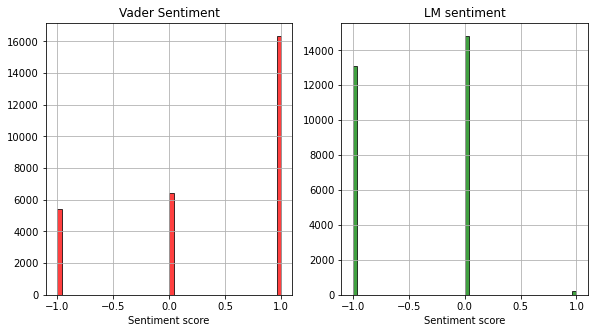

In [14]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['vader_sentiment'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Sentiment score')
plt.title('Vader Sentiment')
plt.grid(True)
plt.subplot(132)
plt.hist(df['lm_sentiment'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Sentiment score')
plt.title('LM sentiment')
# plt.grid(True)
# plt.subplot(133)
# plt.hist(pd.concat([data.compound,data.s_compound]), 
#          50, 
#          color='g',
#          edgecolor = 'black', 
#          alpha=0.75)
# plt.xlabel('Compound Score')
# plt.title('Political News and Stock News')
plt.grid(True)
plt.show()

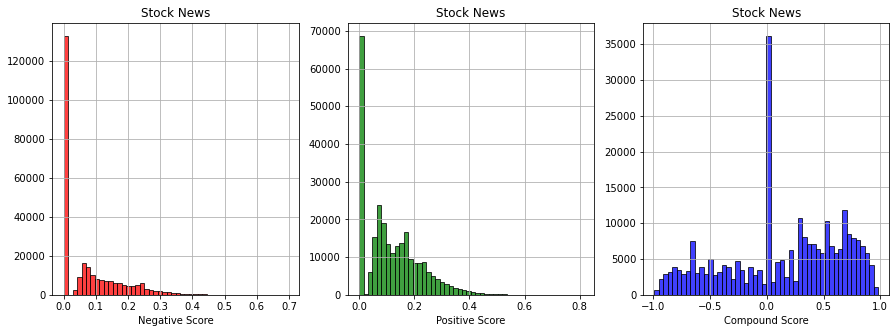

In [10]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['stock_news_vader_neg'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Negative Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(132)
plt.hist(df['stock_news_vader_pos'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Positive Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(133)
plt.hist(df['stock_news_vader_compound'], 
         50, 
         color='b',
         edgecolor = 'black', 
         alpha=0.75)
plt.xlabel('Compound Score')
plt.title('Stock News')
plt.grid(True)
plt.show()

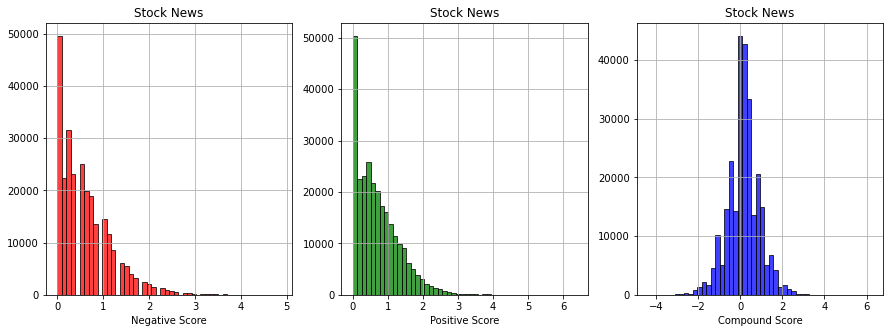

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['stock_news_wordnet_neg'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Negative Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(132)
plt.hist(df['stock_news_wordnet_pos'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Positive Score')
plt.title('Stock News')
plt.grid(True)
plt.subplot(133)
plt.hist(df['stock_news_wordnet_total'], 
         50, 
         color='b',
         edgecolor = 'black', 
         alpha=0.75)
plt.xlabel('Compound Score')
plt.title('Stock News')
plt.grid(True)
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28173 entries, 0 to 881
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   symbol                   28173 non-null  object        
 1   Date                     28173 non-null  datetime64[ns]
 2   article_title            28173 non-null  object        
 3   article_abstract         28173 non-null  object        
 4   article_concat           28173 non-null  object        
 5   article_concat_en        28173 non-null  object        
 6   article_concat_en_split  28173 non-null  object        
 7   vader_sentiment          28173 non-null  int64         
 8   vader_sentiment_pos      28173 non-null  int32         
 9   vader_sentiment_neg      28173 non-null  int32         
 10  lm_sentiment             28173 non-null  int64         
 11  lm_sentiment_pos         28173 non-null  int32         
 12  lm_sentiment_neg         28173 non

In [12]:
df.shape

(28173, 13)

In [13]:
df_sentiment = df.groupby(['symbol', 'Date']) \
    .agg(lm_sentiment_pos=('lm_sentiment_pos', 'sum'), 
         lm_sentiment_neg=('lm_sentiment_neg', 'sum'),
         vader_sentiment_pos=('vader_sentiment_pos', 'sum'), 
         vader_sentiment_neg=('vader_sentiment_neg', 'sum'),) \
    .reset_index()

df_sentiment['stock_daily_sentiment_score_lm'] = df_sentiment \
    .apply(lambda x: daily_sentiment_score(x['lm_sentiment_pos'], x['lm_sentiment_neg']), axis=1)
df_sentiment['stock_daily_sentiment_score_vader'] = df_sentiment \
    .apply(lambda x: daily_sentiment_score(x['vader_sentiment_pos'], x['vader_sentiment_neg']), axis=1)

df_sentiment[['symbol', 'Date', 'stock_daily_sentiment_score_lm', 'stock_daily_sentiment_score_vader']].head()

,symbol,Date,stock_daily_sentiment_score_lm,stock_daily_sentiment_score_vader
0,ACB,2018-03-12,0.0,1.0
1,ACB,2018-04-12,-1.0,1.0
2,ACB,2018-06-12,-1.0,1.0
3,ACB,2018-07-12,0.0,1.0
4,ACB,2018-08-12,-1.0,-1.0


In [14]:
df_sentiment[['symbol', 'Date', 'stock_daily_sentiment_score_lm', 'stock_daily_sentiment_score_vader']] \
    .to_csv('./exported_data/news_sentiment_analysis/vn_stock_news_sentiment_analysis.csv', index=False)